In [1]:
using GLMakie, FastTransforms, LinearAlgebra, MeshGrid, CoherentNoise

In [136]:
N::Int64 = 32 #even
NOISE_SCALE::Float64 = 0.1
STEPS = 100
POLAR_ANGLE = 12.5
dt = 0.01

ϕ::Matrix{Float64}, θ::Matrix{Float64} = meshgrid(LinRange(0.0, 2.0π, 2*N+1), LinRange(-0.5π + deg2rad(POLAR_ANGLE), 0.5π - deg2rad(POLAR_ANGLE), N+1))
l::Matrix{Int64},m::Matrix{Int64} = zeros((N+1,2*N+1)), zeros(N+1,2*N+1)

for li ∈ 1:N+1, mi ∈ 1:2N+1
    l[li, mi] = li + mi ÷ 2 - 1
    m[li, mi] = mi != 1 ? - mi ÷ 2 + (mi - 1) * (mi % 2) : 0
end

In [107]:
function spht(F::Matrix{ComplexF64})::Matrix{ComplexF64}
    P = plan_spinsph2fourier(F, 0)
    PA = plan_spinsph_analysis(F, 0)
    return P\(PA*F)
end

function ispht(F::Matrix{ComplexF64})::Matrix{ComplexF64}
    P = plan_spinsph2fourier(F, 0)
    PS = plan_spinsph_synthesis(F, 0)

    return PS*(P*F)
end

function ϵ(l::Int64, m::Int64)::ComplexF64
    return ((l^2 - m^2) / (4l^2 - 1))^0.5
end

function ∇2S(F::Matrix{ComplexF64})::Matrix{ComplexF64}
    return (-l .* (l .+ 1)) .* F
end

function inv∇2S(F::Matrix{ComplexF64})::Matrix{ComplexF64}
    f = F ./ (-l .* (l .+ 1))
    f[findall(x -> (x.re ∈ [Inf, -Inf, NaN, -NaN]), f)] .= 0.0
    f[1,1] = 0.0
    return f
end

function dθcosθ(ψ_S::Matrix{ComplexF64})::Matrix{ComplexF64}
    ucosθ_S::Matrix{ComplexF64} = zeros(N+1,2*N+1)
    for x ∈ 2:N, y ∈ 1:2*N+1
        li, mi = (l[x,y], m[x,y])
        ucosθ_S[x, y] = (li + 1)ϵ(li, mi)ψ_S[x-1, y] - (li)ϵ(li+1, mi)ψ_S[x+1, y]
    end

    return ucosθ_S
end

function dϕ(F::Matrix{ComplexF64})::Matrix{ComplexF64}
    return im*m .* F
end

function quickmap(F::Matrix)
    fig, ax, hm = heatmap(real.(F))
    Colorbar(fig[:, end+1], hm)

    fig
end

function compute_uv(ω::Matrix{ComplexF64})::Tuple{Matrix{ComplexF64}, Matrix{ComplexF64}}
    ψ::Matrix{ComplexF64} = inv∇2S(spht(ω))
    return (-ispht(dθcosθ(ψ)) ./ cos.(θ), ispht(dϕ(ψ)) ./ cos.(θ))
end

compute_uv (generic function with 1 method)

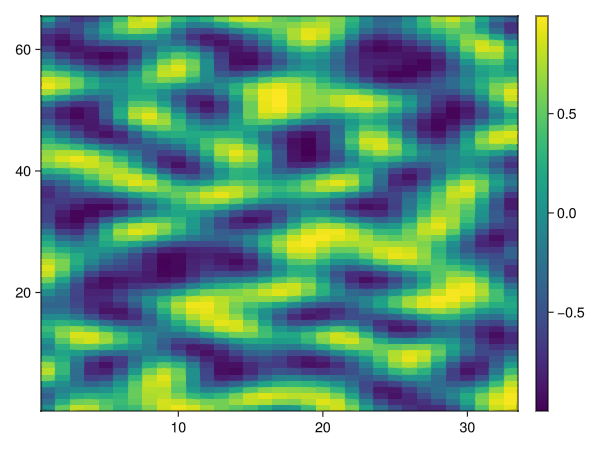

In [137]:
sampler = simplex_2d(seed=42)
ω::Array{ComplexF64} = zeros((N+1, 2*N+1, STEPS))
u::Array{ComplexF64} = zeros((N+1, 2*N+1, STEPS))
v::Array{ComplexF64} = zeros((N+1, 2*N+1, STEPS))

# initial conditions
ω[:,:,1] = [sample(sampler, ϕi, θi) for θi in NOISE_SCALE*(0:N), ϕi in NOISE_SCALE*(0:2*N)]
pert_ω::Matrix{ComplexF64} = cos.(θ)

u[:,:,1], v[:,:,1] = compute_uv(ω[:,:,1])

ω[:,:,2] = ω[:,:,1] + dt*pert_ω
u[:,:,2], v[:,:,2] = compute_uv(ω[:,:,2])

#quickmap(ispht(dθ(inv∇2S(spht(ω[:,:,1])))))
#quickmap(ispht(inv∇2S(spht(ω[:,:,1]))))
quickmap((ω[:,:,1]))

In [141]:
coriolis = ComplexF64.(4π*sin.(θ))

Zu = spht(((coriolis + ω[:,:,1]) .* u[:,:,1]) ./ cos.(θ))
Zv = spht(((coriolis + ω[:,:,1]) .* v[:,:,1]) ./ cos.(θ))

Z = ispht(Zu)

33×65 Matrix{ComplexF64}:
     13.798+2.94638e-17im  …     16.2422+1.96127e-16im
     6.1877-2.08894e-16im        7.58716-5.6102e-17im
    2.14825-1.10631e-16im        2.94995+3.50521e-17im
 -0.0795678-5.023e-16im       -0.0631103-6.59651e-16im
   -1.17037-9.40571e-16im       -1.37823-9.63241e-16im
   -1.70567-3.86313e-16im  …    -1.75594+1.46474e-16im
   -1.60818-2.47388e-16im       -1.48002-1.09834e-16im
   -1.17617+6.85244e-17im      -0.962295+1.63142e-16im
  -0.703281+5.22842e-16im      -0.515002+7.07213e-16im
  -0.411748+5.83539e-17im      -0.291323+8.6808e-17im
  -0.302636-2.88496e-16im  …   -0.287265-2.68855e-16im
  -0.284007+3.1698e-17im       -0.326984+1.16015e-17im
  -0.258164-3.82036e-16im      -0.292192-3.4957e-16im
           ⋮               ⋱  
  -0.904932-1.45082e-16im      -0.880452-1.61314e-16im
   -0.86993+6.88812e-17im      -0.826689+8.49233e-17im
  -0.499989+3.87604e-17im      -0.456788+4.20495e-17im
   0.128307+2.3875e-16im        0.194368+1.95894e-16im
   0.875535

In [15]:
(coriolis + ω) .* u ./ cos.(θ)

LoadError: UndefVarError: `coriolis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.